# Baseline Model Training v2 - With Data Leakage Fix

Improvements over v1:
1. Fix data leakage in `opponent_avg_attendance` (calculate from training data only)
2. Remove redundant `distance` feature (keep only `distance_log`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data and Split by Season FIRST

In [2]:
# Load engineered features
df = pd.read_csv('Data/data_v1/grizzlys_engineered_features.csv')
print(f"Total samples: {len(df)}")
print(f"Original features: {list(df.columns)}")

Total samples: 77
Original features: ['month', 'weekday', 'time_numeric', 'is_weekend', 'season_number', 'opponent_avg_attendance', 'distance', 'distance_log', 'ticket_count']


In [3]:
# Split by season FIRST (before fixing opponent encoding)
# season_number: 0 = 22-23, 1 = 23-24, 2 = 24-25

train_df = df[df['season_number'].isin([0, 1])].copy()
test_df = df[df['season_number'] == 2].copy()

print(f"Training samples: {len(train_df)} (seasons 22-23 & 23-24)")
print(f"Test samples: {len(test_df)} (season 24-25)")

Training samples: 52 (seasons 22-23 & 23-24)
Test samples: 25 (season 24-25)


## 2. Fix Data Leakage: Recalculate opponent_avg_attendance

In [4]:
# Load original data to get away_team names
original_df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')

# Split original data same way
original_train = original_df[original_df['season'].isin(['22-23', '23-24'])].copy()
original_test = original_df[original_df['season'] == '24-25'].copy()

# Calculate opponent averages from TRAINING DATA ONLY
opponent_avg_train = original_train.groupby('away_team')['ticket_count'].mean()
print("Opponent average attendance (from training data only):")
print(opponent_avg_train.sort_values(ascending=False))

Opponent average attendance (from training data only):
away_team
Eisbären Berlin            2310.200000
Düsseldorfer EG            2297.333333
Kölner Haie                2152.000000
Pinguins Bremerhaven       2110.666667
Adler Mannheim             1945.500000
Iserlohn Roosters          1723.000000
EHC Red Bull München       1717.750000
ERC Ingolstadt             1714.000000
SC Bietigheim Steelers     1392.500000
Löwen Frankfurt            1369.250000
Augsburger Panther         1332.000000
Nürnberg Ice Tigers        1301.250000
Straubing Tigers           1136.333333
Schwenninger Wild Wings    1061.000000
Name: ticket_count, dtype: float64


In [5]:
# Apply training-based encoding to both train and test
train_df['opponent_avg_attendance'] = original_train['away_team'].map(opponent_avg_train).values
test_df['opponent_avg_attendance'] = original_test['away_team'].map(opponent_avg_train).values

# Check for any missing mappings in test (new teams)
missing_teams = test_df['opponent_avg_attendance'].isna().sum()
if missing_teams > 0:
    print(f"Warning: {missing_teams} test samples have unknown teams")
    # Fill with training mean as fallback
    test_df['opponent_avg_attendance'].fillna(opponent_avg_train.mean(), inplace=True)
else:
    print("All test teams found in training data")

print(f"\nTraining opponent_avg range: {train_df['opponent_avg_attendance'].min():.0f} - {train_df['opponent_avg_attendance'].max():.0f}")
print(f"Test opponent_avg range: {test_df['opponent_avg_attendance'].min():.0f} - {test_df['opponent_avg_attendance'].max():.0f}")

All test teams found in training data

Training opponent_avg range: 1061 - 2310
Test opponent_avg range: 1061 - 2310


## 3. Remove Redundant Feature

In [6]:
# Remove 'distance' (keep only 'distance_log')
train_df = train_df.drop(columns=['distance'])
test_df = test_df.drop(columns=['distance'])

print("Removed 'distance' feature (keeping 'distance_log' only)")
print(f"\nRemaining columns: {list(train_df.columns)}")

Removed 'distance' feature (keeping 'distance_log' only)

Remaining columns: ['month', 'weekday', 'time_numeric', 'is_weekend', 'season_number', 'opponent_avg_attendance', 'distance_log', 'ticket_count']


## 4. Prepare Features and Target

In [7]:
# Define feature columns (7 features now)
feature_cols = ['month', 'weekday', 'time_numeric', 'is_weekend', 'season_number',
                'opponent_avg_attendance', 'distance_log']
target_col = 'ticket_count'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nSamples per feature ratio: {len(X_train)/len(feature_cols):.1f}")

X_train shape: (52, 7)
X_test shape: (25, 7)

Samples per feature ratio: 7.4


## 5. Preprocessing

In [8]:
# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 6. Define and Train Models

In [9]:
# Define baseline models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}

# Models that need scaled data
scaled_models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

print(f"Training {len(models)} models...")

Training 6 models...


In [10]:
# Train and evaluate
results = []
trained_models = {}

for name, model in models.items():
    # Use scaled data for linear models, unscaled for tree-based
    if name in scaled_models:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values
    
    # Train
    model.fit(X_tr, y_train)
    trained_models[name] = model
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'R²': round(r2, 3)
    })
    
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

Linear Regression: RMSE=616.31, MAE=526.52, R²=-0.424
Ridge Regression: RMSE=604.34, MAE=516.36, R²=-0.369
Lasso Regression: RMSE=612.46, MAE=523.19, R²=-0.406
Random Forest: RMSE=397.22, MAE=329.83, R²=0.409
Gradient Boosting: RMSE=569.28, MAE=435.86, R²=-0.215
XGBoost: RMSE=496.41, MAE=373.79, R²=0.076


## 7. Compare Results

In [11]:
# Results table
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nModel Comparison (sorted by RMSE):")
results_df


Model Comparison (sorted by RMSE):


,Model,RMSE,MAE,R²
3,Random Forest,397.22,329.83,0.409
5,XGBoost,496.41,373.79,0.076
4,Gradient Boosting,569.28,435.86,-0.215
1,Ridge Regression,604.34,516.36,-0.369
2,Lasso Regression,612.46,523.19,-0.406
0,Linear Regression,616.31,526.52,-0.424


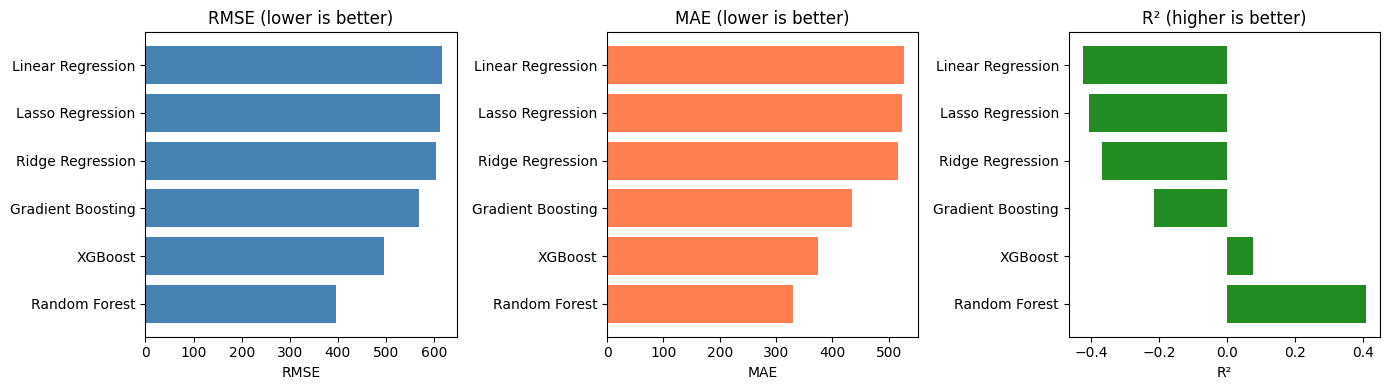

In [12]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# RMSE
axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE')
axes[0].set_title('RMSE (lower is better)')

# MAE
axes[1].barh(results_df['Model'], results_df['MAE'], color='coral')
axes[1].set_xlabel('MAE')
axes[1].set_title('MAE (lower is better)')

# R²
axes[2].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[2].set_xlabel('R²')
axes[2].set_title('R² (higher is better)')

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

Best model: Random Forest


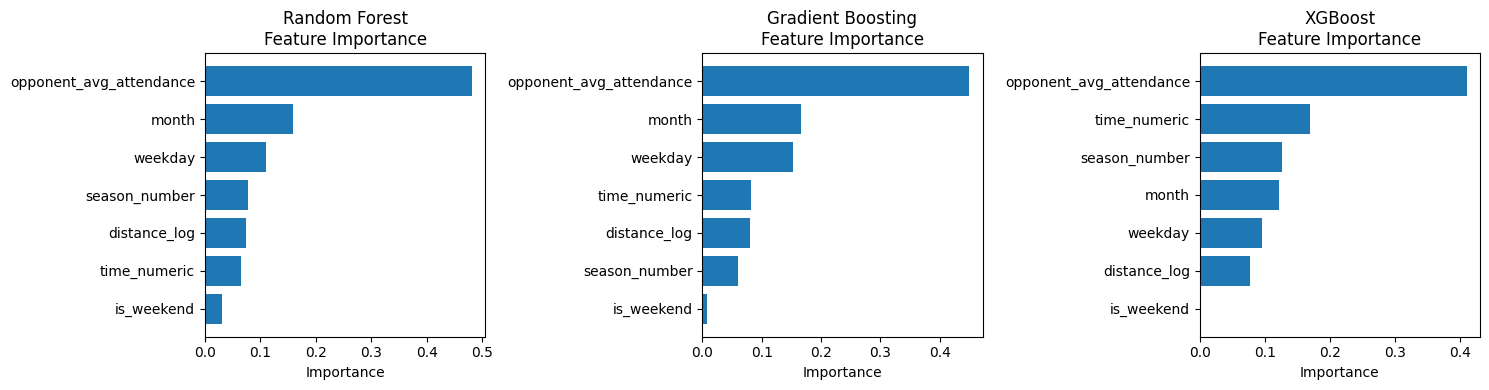

In [13]:
# Get best model name
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Feature importance from tree-based models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

for ax, model_name in zip(axes, tree_models):
    model = trained_models[model_name]
    importance = model.feature_importances_
    
    # Sort by importance
    sorted_idx = np.argsort(importance)
    
    ax.barh([feature_cols[i] for i in sorted_idx], importance[sorted_idx])
    ax.set_title(f'{model_name}\nFeature Importance')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [14]:
# Coefficients from linear models
print("\nLinear Model Coefficients:")
print("="*50)

for model_name in ['Ridge Regression', 'Lasso Regression']:
    model = trained_models[model_name]
    coef_df = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print(f"\n{model_name}:")
    print(coef_df.to_string(index=False))


Linear Model Coefficients:

Ridge Regression:
                Feature  Coefficient
opponent_avg_attendance   370.692209
                  month  -139.693922
          season_number   135.408109
             is_weekend  -106.493326
           time_numeric   -86.064554
                weekday    83.890481
           distance_log    -0.360989

Lasso Regression:
                Feature  Coefficient
opponent_avg_attendance   381.866470
                  month  -140.557422
          season_number   137.307298
             is_weekend  -111.935872
                weekday    90.112438
           time_numeric   -83.902268
           distance_log     6.219634


## 9. Actual vs Predicted Plot

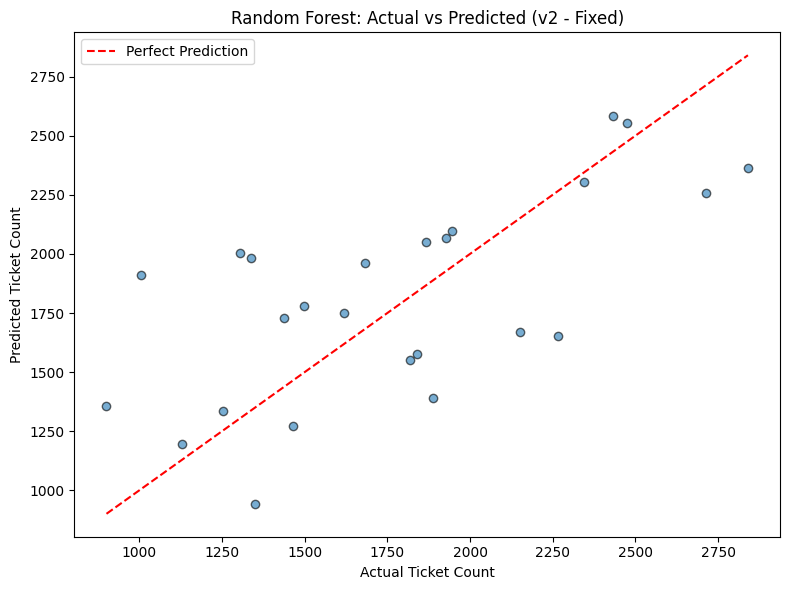


Residual Statistics for Random Forest:
Mean Residual: -33.96
Std Residual: 403.92
Max Over-prediction: -903.49
Max Under-prediction: 614.02


In [15]:
# Plot actual vs predicted for best model
best_model = trained_models[best_model_name]

# Get predictions
if best_model_name in scaled_models:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test.values)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')

# Perfect prediction line
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Ticket Count')
plt.ylabel('Predicted Ticket Count')
plt.title(f'{best_model_name}: Actual vs Predicted (v2 - Fixed)')
plt.legend()
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_pred_best
print(f"\nResidual Statistics for {best_model_name}:")
print(f"Mean Residual: {residuals.mean():.2f}")
print(f"Std Residual: {residuals.std():.2f}")
print(f"Max Over-prediction: {residuals.min():.2f}")
print(f"Max Under-prediction: {residuals.max():.2f}")

## 10. Save Outputs

In [16]:
# Save best model
model_path = f'Models/baseline_model_v2/best_model_{best_model_name.lower().replace(" ", "_")}_v2.joblib'
joblib.dump(best_model, model_path)
print(f"Saved best model to {model_path}")

# Save scaler
scaler_path = 'Models/baseline_model_v2/feature_scaler_v2.joblib'
joblib.dump(scaler, scaler_path)
print(f"Saved scaler to {scaler_path}")

# Save opponent encoding (training-only) for 25-26 predictions
encoding_path = 'Models/baseline_model_v2/opponent_encoding_train_only.json'
with open(encoding_path, 'w') as f:
    json.dump(opponent_avg_train.to_dict(), f, indent=2)
print(f"Saved opponent encoding to {encoding_path}")

# Save results
results_df.to_csv('Models/baseline_model_v2/baseline_model_results_v2.csv', index=False)
print("Saved model comparison results")

Saved best model to Models/baseline_model_v2/best_model_random_forest_v2.joblib
Saved scaler to Models/baseline_model_v2/feature_scaler_v2.joblib
Saved opponent encoding to Models/baseline_model_v2/opponent_encoding_train_only.json
Saved model comparison results


## Summary

**Improvements in v2:**
1. Fixed data leakage: `opponent_avg_attendance` calculated from training data only
2. Removed multicollinearity: dropped `distance` (kept `distance_log`)
3. Better samples-to-features ratio: 52/7 = 7.4 (was 52/8 = 6.5)

**Next steps:**
1. Hyperparameter optimization for best performing models
2. Generate predictions for 25-26 season